In [1]:
%matplotlib inline
from matplotlib import pylab as plt
import theano
from theano import tensor as T
import numpy as np

Using gpu device 0: Tesla K80 (CNMeM is disabled, CuDNN 4007)


In [2]:
#create a regular grid in weight space for visualisation
wmin = -5
wmax = 5
wrange = np.linspace(wmin,wmax,300)
w = np.repeat(wrange[:,None],300,axis=1)
w = np.concatenate([[w.flatten()],[w.T.flatten()]])

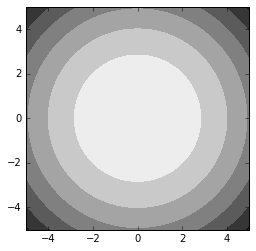

In [3]:
prior_variance = 2
logprior = -(w**2).sum(axis=0)/2/prior_variance
plt.contourf(wrange, wrange, logprior.reshape(300,300), cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

In [4]:
#generating a toy dataset with three manually selected observations
from scipy.stats import logistic
sigmoid = logistic.cdf
logsigmoid = logistic.logcdf

def likelihood(w,x,b=0,y=1):
    return logsigmoid(y*(np.dot(w.T,x) + b)).flatten()


x1 = np.array([[1.5],[1]])
x2 = np.array([[-1.5],[1]])
x3 = np.array([[0.5],[-1]])

y1=1
y2=1
y3=-1

llh1 = likelihood(w, x1, y=y1) 
llh2 = likelihood(w, x2, y=y2) 
llh3 = likelihood(w, x3, y=y3) 

In [5]:
#calculating unnormalised log posterior
#this is only for illustration
logpost = llh1 + llh2 + llh3 + logprior

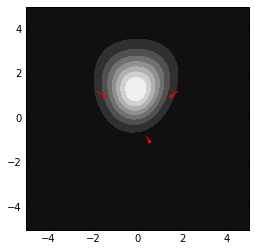

In [6]:
#plotting the real log posterior
#the red dots show the three datapoints, the small line segments shows the direction
#in which the corresponding label shifts the posterior. Positive datapoints shift the 
# posterior away from zero in the direction of the datapoint, negative datapoints shift
# away from zero, in the opposite direction.

plt.contourf(wrange,
             wrange,
             np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])

plt.plot(x1[0],x1[1],'.r')
plt.plot([x1[0],x1[0]*(1+0.2*y1)],[x1[1],x1[1]*(1+0.2*y1)],'r-')

plt.plot(x2[0],x2[1],'.r')
plt.plot([x2[0],x2[0]*(1+0.2*y2)],[x2[1],x2[1]*(1+0.2*y2)],'r-')

plt.plot(x3[0],x3[1],'.r')
plt.plot([x3[0],x3[0]*(1+0.2*y3)],[x3[1],x3[1]*(1+0.2*y3)],'r-');

## Fitting an approximate posterior

This part is for the actual GAN stuff. Here we define the generator and the discriminator networks in Lasagne, and code up the two loss functions in theano.

In [7]:
from lasagne.utils import floatX

from lasagne.layers import (
    InputLayer,
    DenseLayer,
    NonlinearityLayer)
from lasagne.nonlinearities import sigmoid

#defines a 'generator' network
def build_G(input_var=None, num_z = 3):
    
    network = InputLayer(input_var=input_var, shape=(None, num_z))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=2, nonlinearity=None)
    
    return network

#defines the 'discriminator network'
def build_D(input_var=None):

    network = InputLayer(input_var=input_var, shape = (None, 2))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=1, nonlinearity=None)
    
    normalised = NonlinearityLayer(incoming = network, nonlinearity = sigmoid)
    
    return { 'unnorm':network, 'norm':normalised }

In [8]:
from lasagne.layers import get_output, get_all_params
from theano.printing import debugprint
from lasagne.updates import adam
from theano.tensor.shared_randomstreams import RandomStreams

#variables for input (design matrix), output labels, GAN noise variable, weights
x_var = T.matrix('design matrix')
y_var = T.vector('labels')
z_var = T.matrix('GAN noise')
w_var = T.matrix('weights')

#theano variables for things like batchsize, learning rate, etc.
batchsize_var = T.scalar('batchsize', dtype='int32')
prior_variance_var = T.scalar('prior variance')
learningrate_var = T.scalar('learning rate')

#random numbers for sampling from the prior or from the GAN
srng = RandomStreams(seed=1337)
z_rnd = srng.normal((batchsize_var,3))
prior_rnd = srng.normal((batchsize_var,2))

#instantiating the G and D networks
generator = build_G(z_var)
discriminator = build_D()

#these expressions are random samples from the generator and the prior, respectively
samples_from_grenerator = get_output(generator, z_rnd)
samples_from_prior = prior_rnd*T.sqrt(prior_variance_var)

#discriminator output for synthetic samples, both normalised and unnormalised (after/before sigmoid)
D_of_G = get_output(discriminator['norm'], inputs=samples_from_grenerator)
s_of_G = get_output(discriminator['unnorm'], inputs=samples_from_grenerator)

#discriminator output for real samples from the prior
D_of_prior = get_output(discriminator['norm'], inputs=samples_from_prior)

#loss of discriminator - simple binary cross-entropy loss
loss_D = -T.log(D_of_G).mean() - T.log(1-D_of_prior).mean()

#log likelihood for each synthetic w sampled from the generator
log_likelihood = T.log(
    T.nnet.sigmoid(
        (y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * samples_from_grenerator.dimshuffle('x', 1, 0))).sum(1)
    )
).sum(0).mean()

#loss for G is the sum of unnormalised discriminator output and the negative log likelihood
loss_G = s_of_G.mean() - log_likelihood

#compiling theano functions:
evaluate_generator = theano.function(
    [z_var],
    get_output(generator),
    allow_input_downcast=True
)

sample_generator = theano.function(
    [batchsize_var],
    samples_from_grenerator,
    allow_input_downcast=True,
)

sample_prior = theano.function(
    [prior_variance_var, batchsize_var],
    samples_from_prior,
    allow_input_downcast=True
)

params_D = get_all_params(discriminator['norm'], trainable=True)

updates_D = adam(
    loss_D,
    params_D,
    learning_rate = learningrate_var
)

train_D = theano.function(
    [learningrate_var, batchsize_var, prior_variance_var],
    loss_D,
    updates = updates_D,
    allow_input_downcast = True
)

params_G = get_all_params(generator, trainable=True)

updates_G = adam(
    loss_G,
    params_G,
    learning_rate = learningrate_var
)

train_G = theano.function(
    [x_var, y_var, learningrate_var, batchsize_var],
    loss_G,
    updates = updates_G,
    allow_input_downcast = True
)

evaluate_discriminator = theano.function(
    [w_var],
    get_output([discriminator['unnorm'],discriminator['norm']],w_var),
    allow_input_downcast = True
)

#this is to evaluate the log-likelihood of an arbitrary set of w
llh_for_w = T.nnet.sigmoid((y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * w_var.dimshuffle('x', 1, 0))).sum(1))

evaluate_loglikelihood = theano.function(
        [x_var, y_var, w_var],
        llh_for_w,
        allow_input_downcast = True
    )

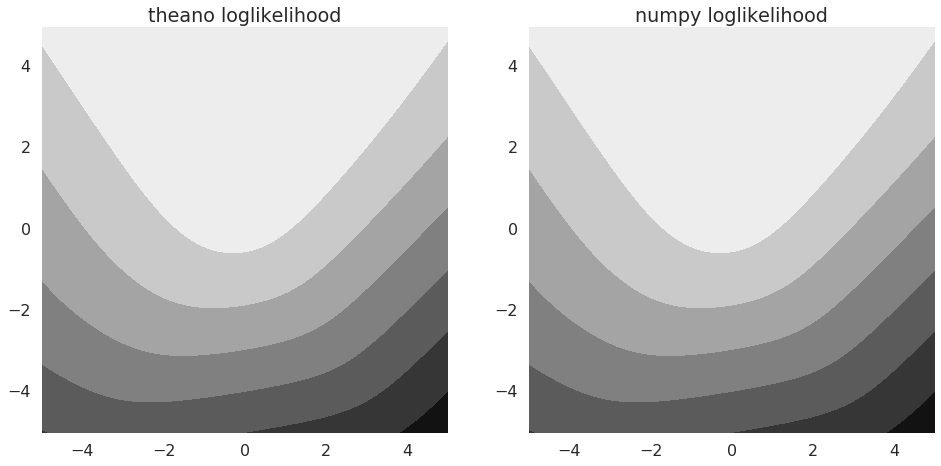

In [9]:
#checking that theano and numpy give the same likelihoods
import seaborn as sns
sns.set_context('poster')

X_train = np.concatenate([x1,x2,x3],axis=1).T
y_train = np.array([y1,y2,y3])
llh_theano = evaluate_loglikelihood(X_train, y_train, w.T)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(wrange, wrange ,np.log(llh_theano).sum(0).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('theano loglikelihood')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('numpy loglikelihood')

assert np.allclose(llh1+llh2+llh3,np.log(llh_theano).sum(0))

In [14]:
batchsize = 200
KARPATHY_CONSTANT = 3e-4
learning_rate = KARPATHY_CONSTANT*10

prior_variance = 2
# train discriminator for some time before starting iterative process
%timeit -n 300 train_D(learning_rate, batchsize, prior_variance)
# print initial values of training errors
print (train_D(0, 100, prior_variance))
print (train_G(X_train, y_train, 0, batchsize))
for i in range(200):
    %timeit -n 50 train_D(learning_rate, batchsize, prior_variance)
    print (train_D(0, 100, prior_variance))
    print (train_G(X_train, y_train, 0, 100))
    train_G(X_train, y_train, learning_rate, batchsize)

300 loops, best of 3: 1.52 ms per loop
0.8448745012283325
1.9514195919036865
50 loops, best of 3: 1.51 ms per loop
0.9600536823272705
2.1756317615509033
50 loops, best of 3: 1.52 ms per loop
1.1132714748382568
2.1207809448242188
50 loops, best of 3: 1.51 ms per loop
0.9374406337738037
2.033437490463257
50 loops, best of 3: 1.51 ms per loop
0.9812651872634888
2.122642993927002
50 loops, best of 3: 1.5 ms per loop
0.9524849653244019
2.1304209232330322
50 loops, best of 3: 1.52 ms per loop
0.9748408198356628
1.9830398559570312
50 loops, best of 3: 1.52 ms per loop
0.9469156265258789
2.034944772720337
50 loops, best of 3: 1.52 ms per loop
1.0123794078826904
2.0215725898742676
50 loops, best of 3: 1.51 ms per loop
0.9374747276306152
1.8552474975585938
50 loops, best of 3: 1.52 ms per loop
0.990984320640564
1.9634348154067993
50 loops, best of 3: 1.52 ms per loop
0.8005599975585938
2.0340428352355957
50 loops, best of 3: 1.5 ms per loop
1.0441194772720337
2.078402042388916
50 loops, best of 

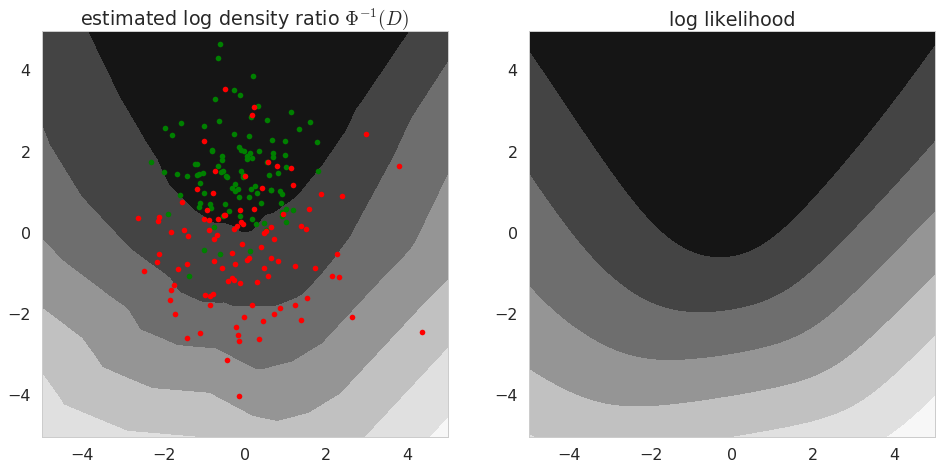

In [15]:
plt.figure(figsize=(16,8))


plt.subplot(1,2,1)
plt.contourf(wrange, wrange, evaluate_discriminator(w.T)[0].reshape(300,300).T)

W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'g.')

W = sample_prior(prior_variance, 100)
plt.plot(W[:,0],W[:,1],'r.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('estimated log density ratio $\Phi^{-1}(D)$')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

plt.title('log likelihood');

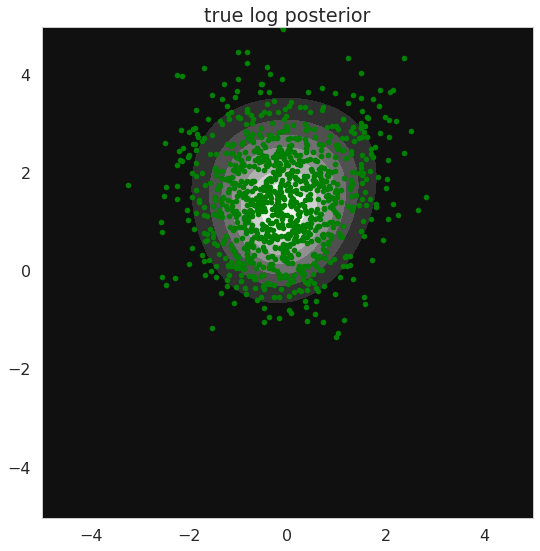

In [16]:
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(1000)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true log posterior');


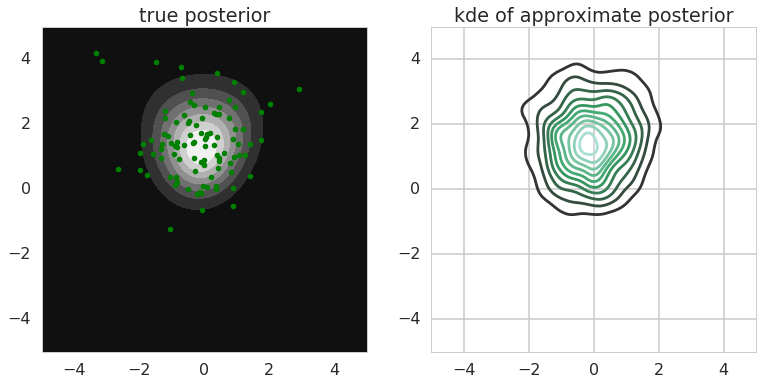

In [17]:
sns.set_style('whitegrid')
plt.subplot(1,2,2)

W = sample_generator(5000)
plot = sns.kdeplot(W[:,0],W[:,1])
plt.axis('square')
plot.set(xlim=(wmin,wmax))
plot.set(ylim=(wmin,wmax))
plt.title('kde of approximate posterior')

plt.subplot(1,2,1)
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true posterior');